In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import time

import gdown
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import get_scorer
from dataheroes import CoresetTreeServiceDTC

encoding = "ISO-8859-1"
# surpress DeprecationWarning
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
MODEL_CLASS = xgb.XGBClassifier
SCORING = "f1" 
scorer_f = get_scorer(scoring = SCORING)
pd.set_option("display.precision", 4)

In [4]:
xgb.__version__

'2.1.4'

### Data Preprocessing

#### Load Credit Card Fraud Dataset
To view more information about the dataset please refer to the next <a href="https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud"> link  </a>

In [5]:
# public folder on Google drive with data
url = "https://drive.google.com/drive/u/0/folders/1x7wSSs3P195Cu4VtylhqHOypwSKQg1OA"
# create local data folder
data_path = pathlib.Path("CreditCard")
data_path.mkdir(parents=True, exist_ok=True)
# download files
if not (data_path / "creditcard.csv").exists():
    gdown.download_folder(url, quiet=True, use_cookies=False, output=str(data_path))

# load data to the memory
df = pd.read_csv(data_path / "creditcard.csv")
X = df.drop("Class", axis=1)
y = df["Class"]
X = X.values
y = y.to_numpy(dtype=int)

In [6]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.3598,-0.0728,2.5363,1.3782,-0.3383,0.4624,0.2396,0.0987,0.3638,...,-0.0183,0.2778,-0.1105,0.0669,0.1285,-0.1891,0.1336,-0.0211,149.62,0
1,0.0,1.1919,0.2662,0.1665,0.4482,0.0600,-0.0824,-0.0788,0.0851,-0.2554,...,-0.2258,-0.6387,0.1013,-0.3398,0.1672,0.1259,-0.0090,0.0147,2.69,0
2,1.0,-1.3584,-1.3402,1.7732,0.3798,-0.5032,1.8005,0.7915,0.2477,-1.5147,...,0.2480,0.7717,0.9094,-0.6893,-0.3276,-0.1391,-0.0554,-0.0598,378.66,0
3,1.0,-0.9663,-0.1852,1.7930,-0.8633,-0.0103,1.2472,0.2376,0.3774,-1.3870,...,-0.1083,0.0053,-0.1903,-1.1756,0.6474,-0.2219,0.0627,0.0615,123.50,0
4,2.0,-1.1582,0.8777,1.5487,0.4030,-0.4072,0.0959,0.5929,-0.2705,0.8177,...,-0.0094,0.7983,-0.1375,0.1413,-0.2060,0.5023,0.2194,0.2152,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.8811,10.0718,-9.8348,-2.0667,-5.3645,-2.6068,-4.9182,7.3053,1.9144,...,0.2135,0.1119,1.0145,-0.5093,1.4368,0.2500,0.9437,0.8237,0.77,0
284803,172787.0,-0.7328,-0.0551,2.0350,-0.7386,0.8682,1.0584,0.0243,0.2949,0.5848,...,0.2142,0.9244,0.0125,-1.0162,-0.6066,-0.3953,0.0685,-0.0535,24.79,0
284804,172788.0,1.9196,-0.3013,-3.2496,-0.5578,2.6305,3.0313,-0.2968,0.7084,0.4325,...,0.2320,0.5782,-0.0375,0.6401,0.2657,-0.0874,0.0045,-0.0266,67.88,0
284805,172788.0,-0.2404,0.5305,0.7025,0.6898,-0.3780,0.6237,-0.6862,0.6791,0.3921,...,0.2652,0.8000,-0.1633,0.1232,-0.5692,0.5467,0.1088,0.1045,10.00,0


In [7]:
# split data into train and test 80% / 20% randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
n_train_instances = len(X_train)
n_test_instances = len(X_test)
print(f"Train size: {n_train_instances}, Test size: {n_test_instances}")

Train size: 227845, Test size: 56962


### Utility Functions

In [8]:
def evaluate_model(model):
    """
    Evaluate a model using the test set
    Parameters
    ----------
    model : object
        The model to evaluate
    Returns
    -------
    tuple
        The evaluation metrics
    """

    prediction = model.predict(X_test)
    prediction_proba = model.predict_proba(X_test)
    # compute scores
    balanced_acc = balanced_accuracy_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction_proba[:, 1], average="weighted")
    auprc = average_precision_score(y_test, prediction_proba[:, 1], average="weighted")
    log_loss_score = log_loss(y_test, prediction_proba[:, 1])
    return balanced_acc, f1, precision, recall, roc_auc, auprc, log_loss_score

## Data tuning

### Create a service with multiple trees

In [9]:
# Class split
classes, counts = np.unique(y_train, return_counts=True)
print(classes, counts)
class_size = [{1: int(p * counts[1] / 4)} for p in [1.00, 0.95, 0.90, 0.85]]
class_size

[0 1] [227451    394]


[{1: 98}, {1: 93}, {1: 88}, {1: 83}]

In [10]:
data_tuning_params = {
    "coreset_size": [0.40],
    "deterministic_size": [0.0, 0.1, 0.2, 0.3],
    "det_weights_behaviour": ['keep', 'inv', 'prop'],
    "class_size": class_size,
    "fair": [False],
}

In [11]:
service_obj = CoresetTreeServiceDTC(
    n_instances=X_train.shape[0],
    data_tuning_params=data_tuning_params,
    model_cls=xgb.XGBClassifier,
)
service_obj.build(X_train, y_train, copy=True)

2025-04-28 12:41:47 Build Started.
2025-04-28 12:41:47 Completed chunk #1 out of 4 chunks, (chunk was built in 0.032 seconds)
2025-04-28 12:41:50 Completed chunk #2 out of 4 chunks, (chunk was built in 0.048 seconds)
2025-04-28 12:42:00 Completed chunk #3 out of 4 chunks, (chunk was built in 0.084 seconds)
2025-04-28 12:42:05 Completed chunk #4 out of 4 chunks, (chunk was built in 0.097 seconds)
2025-04-28 12:42:22 Build Completed in: 0:00:34.896.


In [12]:
# Print the number of trees
len(service_obj.trees)

48

{0: None}

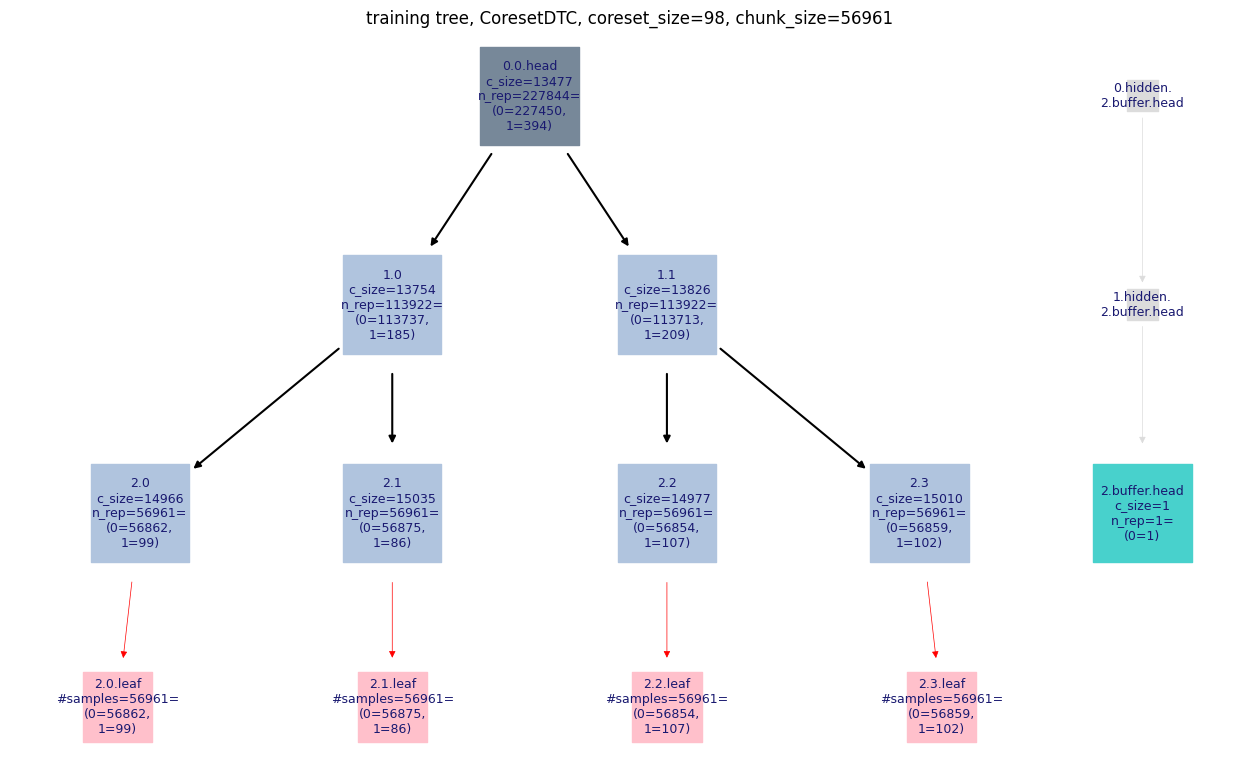

In [13]:
# Plotting the first tree, all trees have the same structure
service_obj.plot(tree_indices=[0])

### Run Data Tuning

In [14]:
# Running grid_search over the created trees
# We ignore the first value which is the best model params because we use the default params
t_gs = time.time()
_, best_tree, df_all_runs, best_model = service_obj.grid_search(
    param_grid={}, validation_method="cross validation", scoring=SCORING
)
t_gs = time.time() - t_gs 
print(f"Grid search on {len(service_obj.trees)} trees ran in {t_gs:.4f}s")

Grid search on 48 trees ran in 303.7304s


In [15]:
df_all_runs.sort_values(by = "mean_folds_score", ascending = False)

,mean_folds_score,Fold 0,Fold 1,Fold 2,Fold 3,tree_idx,coreset_size,det_weights_behaviour,deterministic_size,sample_all,class_size,fair
3,0.8570,0.8457,0.8342,0.8743,0.8737,3,0.4,keep,0.3,None,{1: 98},False
39,0.8563,0.8701,0.8438,0.8605,0.8511,39,0.4,keep,0.3,None,{1: 83},False
37,0.8558,0.8439,0.8511,0.8757,0.8525,37,0.4,keep,0.1,None,{1: 83},False
28,0.8547,0.8409,0.8466,0.8485,0.8830,28,0.4,inv,0.0,None,{1: 88},False
14,0.8541,0.8439,0.8526,0.8675,0.8525,14,0.4,keep,0.2,None,{1: 93},False
4,0.8504,0.8372,0.8421,0.8588,0.8634,4,0.4,inv,0.0,None,{1: 98},False
22,0.8491,0.8166,0.8449,0.8485,0.8865,22,0.4,prop,0.2,None,{1: 93},False
26,0.8483,0.8439,0.8342,0.8639,0.8511,26,0.4,keep,0.2,None,{1: 88},False
25,0.8479,0.8439,0.8526,0.8554,0.8398,25,0.4,keep,0.1,None,{1: 88},False
24,0.8471,0.8229,0.8280,0.8606,0.8770,24,0.4,keep,0.0,None,{1: 88},False


In [16]:
print(f"{scorer_f(best_model, X_test, y_test):.4f}")

0.8696


### Train a model on the full dataset

In [17]:
t_full = time.time()
model_full = MODEL_CLASS().fit(X=X_train, y=y_train)
t_full = time.time() - t_full
print(f"Training on the full dataset ran in {t_full:.4f}s")

Training on the full dataset ran in 1.5902s


In [18]:
print(f"{scorer_f(model_full, X_test, y_test):.4f}")

0.8587


In [19]:
stats = {}
stats["Full_data"] = evaluate_model(model_full)
stats["Full_data"] += (t_full,)
stats["Data_Tuning"] = evaluate_model(best_model)
stats["Data_Tuning"] += (t_gs,)
stats_df = pd.DataFrame(stats).T
stats_df.columns = ["Balanced accuracy", "F1", "Precision", "Recall", "ROC AUC", "AUPRC", "Log loss", "Time"]

stats_df

,Balanced accuracy,F1,Precision,Recall,ROC AUC,AUPRC,Log loss,Time
Full_data,0.9030,0.8587,0.9186,0.8061,0.9743,0.8777,0.0028,1.5902
Data_Tuning,0.9081,0.8696,0.9302,0.8163,0.9722,0.8693,0.0029,303.7304


### Grid search with model params

In [20]:
param_grid = {
    "learning_rate": [0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 150, 250],
    "max_depth": [4, 6, 8],
}

In [21]:
# Pick the best 3 trees
best_trees = list(df_all_runs["mean_folds_score"].sort_values(ascending=False).head(3).index)
print(best_trees)

[3, 39, 37]


In [22]:
# Get the best trees and print their data tuning parameters
service_obj.trees_data_tuning_params(as_df=True).loc[best_trees]

,coreset_size,det_weights_behaviour,deterministic_size,sample_all,class_size,fair
3,0.4,keep,0.3,None,{1: 98},False
39,0.4,keep,0.3,None,{1: 83},False
37,0.4,keep,0.1,None,{1: 83},False


In [23]:
t_gs = time.time()
best_model_params, best_tree, df_all_runs, best_model = service_obj.grid_search(
    param_grid=param_grid, validation_method="cross validation", scoring=SCORING, tree_indices=best_trees
)
t_gs = time.time() - t_gs
print(f"Grid search on {len(best_trees)} trees ran in {t_gs:.4f}s")

Grid search on 3 trees ran in 742.1919s


In [24]:
# Query the df with all runs for the best run
query_str = " and ".join(f"{col} == {val}" for col, val in best_model_params.items())
query_str += f" and tree_idx == {best_tree}"

df_best = df_all_runs.query(query_str)
df_best

,mean_folds_score,Fold 0,Fold 1,Fold 2,Fold 3,n_estimators,max_depth,learning_rate,tree_idx,coreset_size,det_weights_behaviour,deterministic_size,sample_all,class_size,fair
14,0.8622,0.8475,0.881,0.8466,0.8737,250,4,0.1,3,0.4,keep,0.3,None,{1: 98},False


In [25]:
print(f"{scorer_f(best_model, X_test, y_test):.4f}")

0.8681


### Full model grid search

In [26]:
model_full = GridSearchCV(estimator=MODEL_CLASS(), param_grid=param_grid, cv=4, scoring=SCORING, verbose = 1)

In [27]:
t_gs_full = time.time()
model_full.fit(X_train, y_train)
t_gs_full = time.time() - t_gs_full
print(f"Grid search on the full dataset ran in {t_gs_full:.4f}s")

Fitting 4 folds for each of 36 candidates, totalling 144 fits
Grid search on the full dataset ran in 878.0285s


In [28]:
# Look at some statistics from GridSearchCV.
cols = ["mean_test_score"] + [s  for s in model_full.cv_results_.keys() if s.startswith("split")]
df_params_full= pd.DataFrame(model_full.cv_results_["params"])
df_gs_full = pd.concat([pd.DataFrame(model_full.cv_results_)[cols], df_params_full], axis = 1)

# Get best score and pretty print it
df_gs_full.sort_values(by = "mean_test_score", ascending=False).iloc[0].to_frame().T

,mean_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,learning_rate,max_depth,n_estimators
19,0.8585,0.8571,0.875,0.8324,0.8696,0.2,4.0,150.0


In [29]:
print(f"{scorer_f(model_full, X_test, y_test):.4f}")

0.8634


In [30]:
model_full.best_params_

{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 150}

In [31]:
stats = {}
stats["Full_data"] = evaluate_model(model_full)
stats["Full_data"] += (t_gs_full,)
stats["Data_Tuning"] = evaluate_model(best_model)
stats["Data_Tuning"] += (t_gs,)
stats_df = pd.DataFrame(stats).T
stats_df.columns = ["Balanced accuracy", "F1", "Precision", "Recall", "ROC AUC", "AUPRC", "Log loss", "Time"]

stats_df

,Balanced accuracy,F1,Precision,Recall,ROC AUC,AUPRC,Log loss,Time
Full_data,0.903,0.8634,0.9294,0.8061,0.9798,0.8746,0.0026,878.0285
Data_Tuning,0.903,0.8681,0.9405,0.8061,0.9847,0.8744,0.0025,742.1919
